# **Kinetic Monte Carlo: Esercizio 2 punto 1**

We model growth on the (001) Ag surface using a ℎ(𝑥,𝑦) solid-on-solid representation on a square lattice. A 𝐿 × 𝐿 = 60 × 60 periodic cell is considered, unless differently indicated. Atomic interactions are limited to first-neighbors only, with bonding energy 𝐽1 = − 0.345 𝑒𝑉. Each Ag atom is bonded to 4 neighbors from the underlying layer, i.e. 𝐽0 = 4𝐽1, and can form up to 4 lateral bonds (each of energy 𝐽1) with atoms in adjacent columns.


## *SVOLGIMENTO PUNTO 1*

Perform a simulation of deposition only (0 𝐾, i.e. no diffusion) with 𝜙 = 0.2 𝑀𝐿/𝑠 up to a nominal
coverage 𝜃 = 5 𝑀𝐿

---

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MonteCarlo.KineticMonteCarlo import KineticMonteCarlo

### #) Simulazione

Poiché $T=0 \text{ K}$, le diffusioni sono soppresse:
$$
\lim_{T\to0} k_\text{diff} 
\approx 
\lim_{T\to0} \nu e^{-\frac{E_b}{k_B T}} = 0 
\implies
k_\text{tot} 
\equiv 
k_\text{depo} = \phi L_x L_y
$$

$$
k_\text{diff} \approx \nu e^{-\frac{E_b}{k_B T}} \xrightarrow{T\to0} 0 
$$
$$
k_\text{depo} = \phi L_x L_y
$$

#### Dati

In [2]:
flux = 0.2 # ML/s monolayers per secondo
temperature = 0  # K
nominal_coverage = 5.0  # ML monolayers 
simulation_time = nominal_coverage / flux  # s secondi
L = (60,60) # dimensioni della griglia in unità di celle cristalline

In [3]:
from CMS.MonteCarlo.ioKMC import XYZwriter
max_write_steps = int(L[0] * L[1] * 0.3) # salvo il 30% delle deposizioni
xyz_writer = XYZwriter(output_folder=f"output/2_1/30%layer_f=0.2_ML_per_s/",
                       max_deposition_steps=max_write_steps)

In [4]:
simulation = KineticMonteCarlo(L=L, 
                               flux=flux, 
                               T=temperature, 
                               seed=42,
                               xyz_writer=xyz_writer)
result = simulation.run(end_time=simulation_time)

In [5]:
result.dt_list

array([0.00136397, 0.00071259, 0.0039526 , ..., 0.00111022, 0.00099965,
       0.00323358], shape=(18185,))

---

## Analisi risultati

Analyze the sequence of escape times 𝜏 extracted for each deposition event and test that their average corresponds to the reciprocal of total deposition rate and check that 𝜏 values distribute with the expected exponential distribution. Observe the morphology of the deposited film and the square-root behavior of 𝜎 𝜃 .

### Distribuzione tau

Istogramma dei valori di $\tau$ generati durante la simulazione

In [6]:
def espected_tau_pdf (k_depo, x):
    return k_depo * np.exp(-k_depo * x)

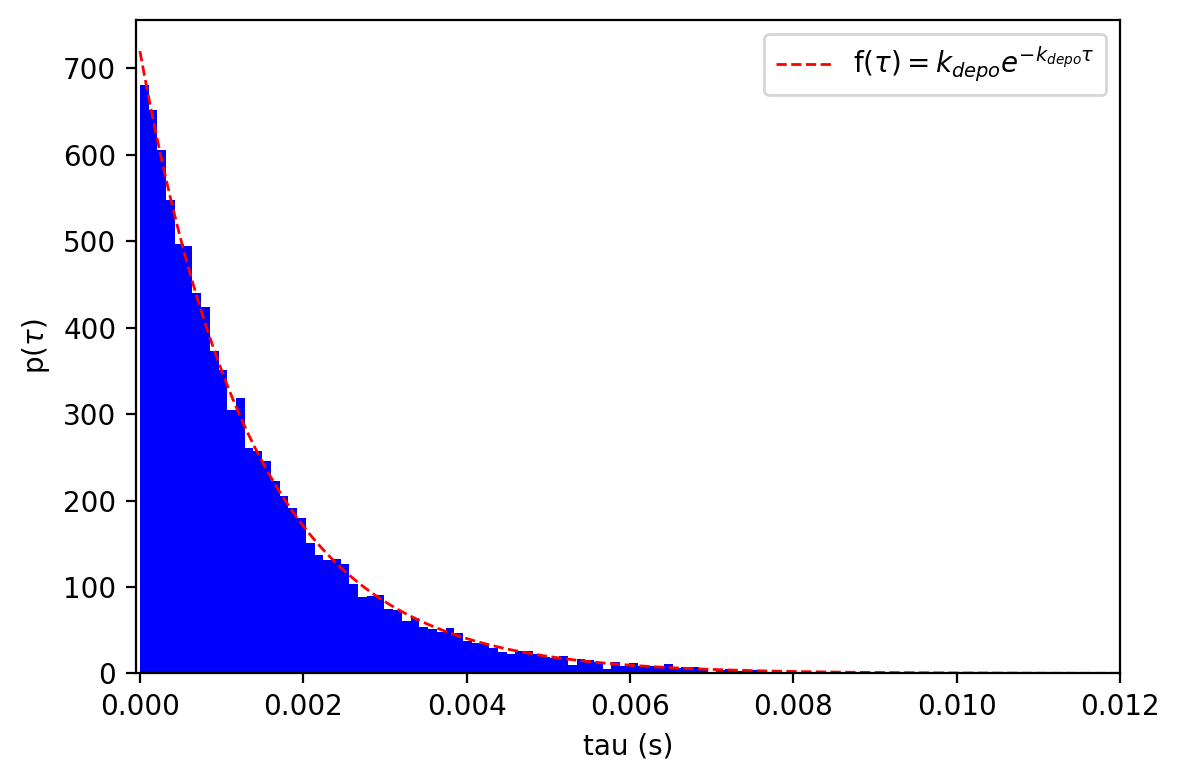

In [7]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x = result.dt_list # T=0, ergo dt coincide con tau perché ho solo eventi di deposizione
n = len(x)
n_bins = round(np.sqrt(n))

x_curve = np.linspace(min(min(x),0.001), max(x), n)
y_curve = espected_tau_pdf(result.k_depo, x_curve)

# plot #
plt.figure(figsize=(6,4), dpi=200)
# istogramma NORMALIZZATO (con density=True diventa una pdf)
y, bins, _ =plt.hist(x, bins=n_bins, density=True, color='blue')
# curva teorica
plt.plot(x_curve, y_curve,
         label='f($\\tau)=k_{depo}e^{-k_{depo}\\tau}$', 
         color='red', 
         linestyle='--',
         linewidth=1)

plt.xlabel('tau (s)')
plt.ylabel('p($\\tau$)')
plt.legend()
plt.xlim(-0.00005, 0.012)
#plt.ylim(0, 700)
plt.tight_layout()
plt.show()

**test che sia come il reciproco del deposition rate**

In [8]:
np.mean(result.dt_list)

np.float64(0.0013747255359195208)

In [9]:
# reciproco del tasso di deposizione
1/result.k_depo

0.001388888888888889

$$
\bar\tau \simeq 0.00137,
\quad
\frac{1}{k_\text{depo}} \equiv \langle\tau\rangle \simeq 0.00139

Molto simili!

### Plot roughness

Observe the morphology of the deposited film and the square-root behavior of 𝜎(𝜃). Perché *Stick-Where-You-Hit* ha questo comportamento radice?

$$
\langle h\rangle = \frac{n}{L_x L_y} := \lambda,
\quad
\sigma_h = \sqrt{\lambda} 
$$

In [10]:
def radice_quad(x, A):
    return A * np.sqrt(x)

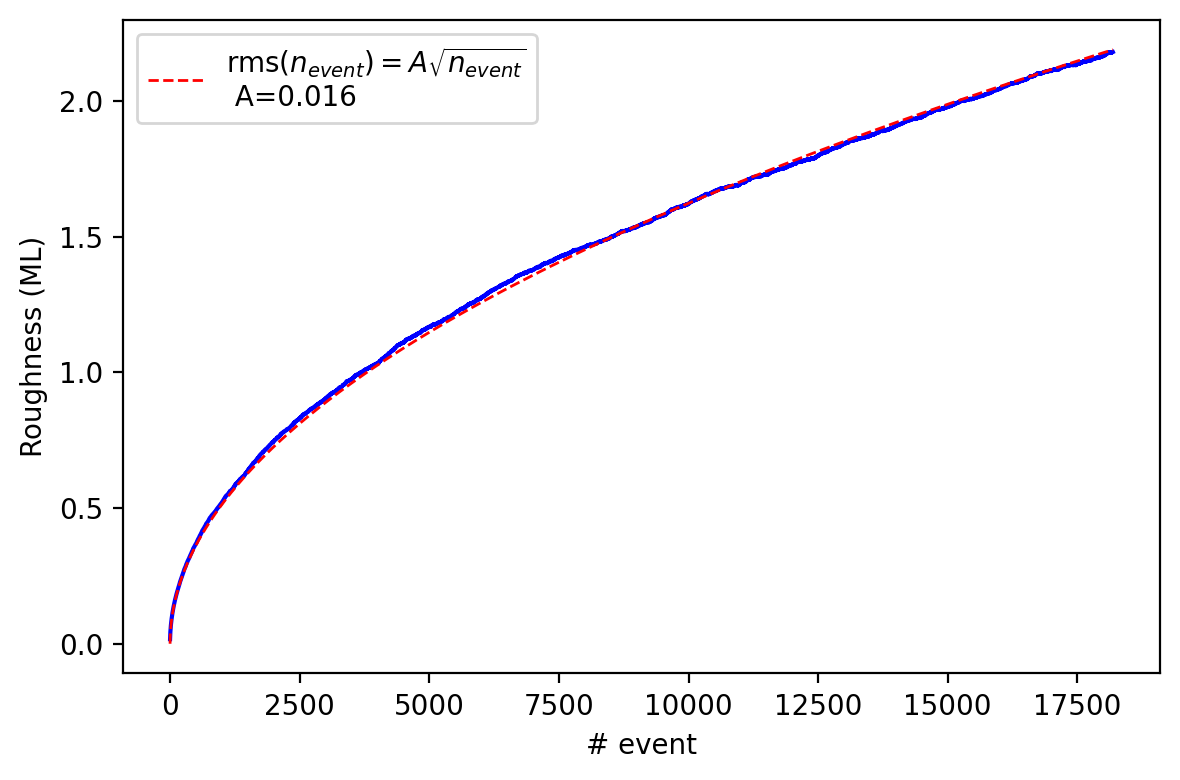

In [11]:
x = np.arange(len(result.rms_roughness_list))
y = result.rms_roughness_list

plt.figure(figsize=(6,4), dpi=200)
# plot #
plt.plot(x, y, color='blue')
# fit #
popt, pcov = curve_fit(radice_quad, x, y, p0=[1.0])
A_fit = popt[0]
# curva di fit
y_fit = radice_quad(x, A_fit)
plt.plot(x, y_fit,
         label=f"rms($n_{{event}})=A\\sqrt{{n_{{event}}}}$ \n A={A_fit:.3f}",
         color='red',
         linestyle='--',
         linewidth=1)
plt.legend()
plt.xlabel('# event')
plt.ylabel('Roughness (ML)')
plt.tight_layout()
plt.show()